In [129]:
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial

from jax_vi import KL_gaussian, log_likelihood, KL_sum
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix




key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
num_steps = 100 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
q = random.normal(key, (n, n))/5
Q = q@q.T + jnp.eye(n)*0.1#jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)

Q = jnp.eye(n) * 0.1    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 0.5    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1

# State initialization
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)


In [130]:
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = observations

In [131]:
from functools import partial


@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, H, Q, R, y, key, num_steps, J0):
    states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K, n, l96_step, jac_func, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(states, covariances, n, l96_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, states, covariances), y, H, R, num_steps, J0) 
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost


In [132]:
m, C, K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
print(K[-1])
K_steady = jnp.mean(K[-10:, :, :], axis=0)

[[ 3.51721913e-01  6.70830682e-02  7.49488390e-05 ...  1.08290045e-03
  -7.39945024e-02  4.96778637e-02]
 [ 6.70831054e-02  3.35822493e-01 -3.32197128e-03 ...  5.15935710e-03
  -1.06678382e-02 -1.79709159e-02]
 [ 7.49518222e-05 -3.32198525e-03  3.97926182e-01 ...  2.61667673e-03
  -3.27576115e-03 -4.61601606e-03]
 ...
 [ 1.08289660e-03  5.15935104e-03  2.61667534e-03 ...  3.69979978e-01
   5.05407788e-02 -5.41505292e-02]
 [-7.39945546e-02 -1.06678335e-02 -3.27575766e-03 ...  5.05407751e-02
   4.03110325e-01 -3.38249281e-02]
 [ 4.96778935e-02 -1.79709122e-02 -4.61601652e-03 ... -5.41505218e-02
  -3.38249281e-02  3.39696914e-01]]


In [135]:
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy import linalg as jnpl
from tqdm.auto import tqdm

var_cost_grad = grad(var_cost, argnums=0)

# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4
alpha = 1e-5


prediction_errors = [] 
norms = []
true_div = []

n_iters = 100

for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, H, Q, R, y, key, num_steps, J0)
    K_opt -= alpha * grad_K
    
    # Apply filtering with the newly optimized K to generate state predictions
    predicted_states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
    
    prediction_error = np.mean(np.mean((predicted_states - true_states)**2, axis=1))
    prediction_errors.append(prediction_error)
    norms.append(jnpl.norm(K_opt - K_steady))
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / num_steps)

  0%|          | 0/100 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>


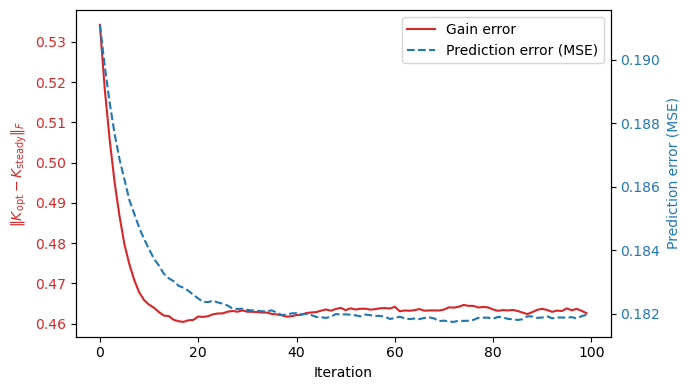

In [150]:
fig, ax1 = plt.subplots(figsize=(7, 4))

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\|K_\mathrm{opt} - K_\mathrm{steady}\|_F$', color=color)
ax1.plot(norms, label='Gain error', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Prediction error (MSE)', color=color)
ax2.plot(prediction_errors, label='Prediction error (MSE)', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
fig.tight_layout()
#plt.title('Optimization and Prediction Errors over Iterations')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.savefig("nonlinear_gain_errors.pdf")
#plt.show()

In [151]:
# import matplotlib.pyplot as plt

# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Optimization Error
# color = 'tab:red'
# ax1.set_xlabel('Iteration')
# ax1.set_ylabel('Optimization Error (K_opt - K_steady Norm)', color=color)
# #ax1.plot(norms, label='Optimization Error (K_opt - K_steady Norm)', color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# # Instantiate a second y-axis for Prediction Error and True Divergence
# ax2 = ax1.twinx()
# color_pred = 'tab:blue'
# ax2.set_ylabel('Prediction Error & True Divergence', color=color_pred)
# line1, = ax2.plot(prediction_errors, label='Prediction Error (MSE)', color=color_pred, linestyle='--')
# line2, = ax2.plot(true_div, label='True Divergence', color='tab:green', linestyle='-.')
# ax2.tick_params(axis='y', labelcolor=color_pred)

# # Title and combined legend
# plt.title('Optimization and Prediction Errors over Iterations')

# # Creating a combined legend for all lines
# lines = [line1, line2]
# labels = [line.get_label() for line in lines]
# ax1.legend(lines, labels, loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# plt.tight_layout()
# plt.show()


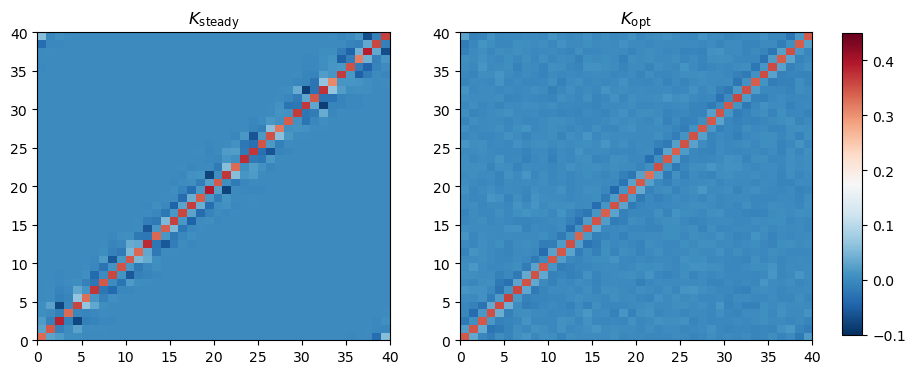

In [153]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.pcolormesh(K_steady, vmin=-0.1, vmax=0.45, cmap='RdBu_r')
ax1.set_title('$K_\mathrm{steady}$')
p2 = ax2.pcolormesh(K_opt, vmin=-0.1, vmax=0.45, cmap='RdBu_r')
ax2.set_title('$K_\mathrm{opt}$')
cb_ax = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(p2,orientation='vertical',cax=cb_ax)

plt.savefig("nonlinear_gains.pdf")